<a href="https://colab.research.google.com/github/vgaurav3011/100-Days-of-ML/blob/master/catsvsdogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
itfrom google.colab import drive
drive.mount('/content/drive')
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


!pip install bokeh
from keras.callbacks import *
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,sgd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),#148
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),#74
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),#36
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),#17
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),#7
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),#5
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),#3
    tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid'),#1
    tf.keras.layers.Flatten(),
])



# This code has changed. Now instead of the ImageGenerator just rescaling
# the image, we also rotate and do other operations
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      zca_whitening=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

filepath="/content/drive/My Drive/Colab Notebooks/weights.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor='val_acc', verbose=1,save_weights_only=False, save_best_only=True)  
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2020-01-16 18:55:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   204MB/s    in 0.3s    

2020-01-16 18:55:47 (204 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
#Cyclic Learning Rate
class CyclicLR(Callback):
  

    def __init__(self, base_lr=0.00000005, max_lr=0.009, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
def find_lr(model, start_lr, end_lr):
    finder = LRFinder(start_lr, end_lr, len(train_generator))
    weights = model.get_weights()    
    try:
        history = model.fit_generator(
            generator=train_generator,
            validation_data=validation_generator,
            epochs=1,
            verbose=1,
            callbacks=[finder],
        )   
    finally:    
        model.set_weights(weights)    
    return finder
    
class LRFinder(Callback):    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  

    def plot(self, lskip=10, rskip=10):
        lrs = self.lrs[lskip:-rskip]
        losses = self.smoothed_losses[lskip:-rskip]

        output_notebook()
        p = figure(title='Learning Rate Finder', x_axis_label='LR', y_axis_label='Loss')
        p.line(lrs, losses)
        show(p)
        
        best_idxs = np.argpartition(losses, 15)[:15]
        best_lrs = np.take(lrs, best_idxs)
        print(f"Best LRs: {best_lrs}")  

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)      

In [0]:
opt = RMSprop(lr=0.001)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=["acc"])
#finder = find_lr(model, 1e-7, 1e-2)
#finder.plot()



In [0]:

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.50200, saving model to /content/drive/My Drive/Colab Notebooks/weights.01-0.50.hdf5
100/100 - 25s - loss: 0.7221 - acc: 0.5595 - val_loss: 0.7226 - val_acc: 0.5020
Epoch 2/100
Epoch 1/100

Epoch 00002: val_acc improved from 0.50200 to 0.51000, saving model to /content/drive/My Drive/Colab Notebooks/weights.02-0.51.hdf5
100/100 - 16s - loss: 0.6902 - acc: 0.5670 - val_loss: 0.6938 - val_acc: 0.5100
Epoch 3/100
Epoch 1/100

Epoch 00003: val_acc improved from 0.51000 to 0.52000, saving model to /content/drive/My Drive/Colab Notebooks/weights.03-0.52.hdf5
100/100 - 16s - loss: 0.6822 - acc: 0.5700 - val_loss: 0.7214 - val_acc: 0.5200
Epoch 4/100
Epoch 1/100

Epoch 00004: val_acc improved from 0.52000 to 0.57500, saving model to /content/drive/My Drive/Colab Notebooks/weights.04-0.57.hdf5
100/100 - 17s - loss: 0.6701 - acc: 0.5865 - val_loss: 0.7650 - val_acc: 0.5750
Epoch 5/100
Epoch 1/100

Epoch 00005: val_acc improved from 0.57500

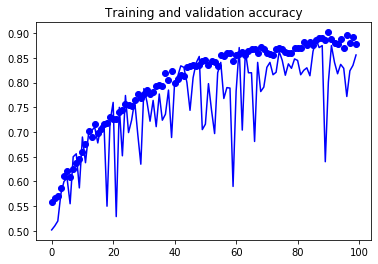

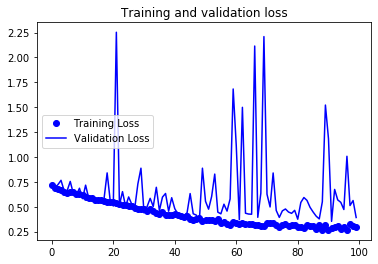

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.0001)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=["acc"])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20

Epoch 00001: val_acc did not improve from 0.88700
100/100 - 19s - loss: 0.2357 - acc: 0.8975 - val_loss: 0.3640 - val_acc: 0.8760
Epoch 2/20
Epoch 1/20

Epoch 00002: val_acc did not improve from 0.88700
100/100 - 16s - loss: 0.2359 - acc: 0.8985 - val_loss: 0.3856 - val_acc: 0.8730
Epoch 3/20
Epoch 1/20

Epoch 00003: val_acc did not improve from 0.88700
100/100 - 16s - loss: 0.2249 - acc: 0.9150 - val_loss: 0.3767 - val_acc: 0.8760
Epoch 4/20
Epoch 1/20

Epoch 00004: val_acc did not improve from 0.88700
100/100 - 16s - loss: 0.2337 - acc: 0.9080 - val_loss: 0.3750 - val_acc: 0.8790
Epoch 5/20
Epoch 1/20

Epoch 00005: val_acc did not improve from 0.88700
100/100 - 17s - loss: 0.2379 - acc: 0.9005 - val_loss: 0.3739 - val_acc: 0.8820
Epoch 6/20
Epoch 1/20

Epoch 00006: val_acc did not improve from 0.88700
100/100 - 17s - loss: 0.2343 - acc: 0.9100 - val_loss: 0.3735 - val_acc: 0.8850
Epoch 7/20
Epoch 1/20

Epoch 00007: val_acc did not improve from 0.88700
100/100 - 17s - loss

In [0]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0005)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=["acc"])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20

Epoch 00001: val_acc did not improve from 0.89100
100/100 - 20s - loss: 0.2415 - acc: 0.8990 - val_loss: 0.4981 - val_acc: 0.8510
Epoch 2/20
Epoch 1/20

Epoch 00002: val_acc did not improve from 0.89100
100/100 - 18s - loss: 0.2594 - acc: 0.8975 - val_loss: 0.4518 - val_acc: 0.8710
Epoch 3/20
Epoch 1/20

Epoch 00003: val_acc did not improve from 0.89100
100/100 - 18s - loss: 0.2067 - acc: 0.9125 - val_loss: 0.3530 - val_acc: 0.8870
Epoch 4/20
Epoch 1/20

Epoch 00004: val_acc did not improve from 0.89100
100/100 - 18s - loss: 0.2208 - acc: 0.9080 - val_loss: 0.3909 - val_acc: 0.8690
Epoch 5/20
Epoch 1/20

Epoch 00005: val_acc did not improve from 0.89100
100/100 - 18s - loss: 0.1962 - acc: 0.9165 - val_loss: 0.4477 - val_acc: 0.8630
Epoch 6/20
Epoch 1/20

Epoch 00006: val_acc did not improve from 0.89100
100/100 - 18s - loss: 0.2160 - acc: 0.9125 - val_loss: 0.4568 - val_acc: 0.8540
Epoch 7/20
Epoch 1/20

Epoch 00007: val_acc did not improve from 0.89100
100/100 - 18s - loss

In [0]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.0001)
model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=["acc"])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2,callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100

Epoch 00001: val_acc did not improve from 0.89900
100/100 - 19s - loss: 0.1778 - acc: 0.9265 - val_loss: 0.3319 - val_acc: 0.8840
Epoch 2/100
Epoch 1/100

Epoch 00002: val_acc did not improve from 0.89900
100/100 - 17s - loss: 0.1454 - acc: 0.9475 - val_loss: 0.3257 - val_acc: 0.8920
Epoch 3/100
Epoch 1/100

Epoch 00003: val_acc did not improve from 0.89900
100/100 - 18s - loss: 0.1645 - acc: 0.9335 - val_loss: 0.3249 - val_acc: 0.8910
Epoch 4/100
Epoch 1/100

Epoch 00004: val_acc did not improve from 0.89900
100/100 - 17s - loss: 0.1490 - acc: 0.9415 - val_loss: 0.3263 - val_acc: 0.8900
Epoch 5/100
Epoch 1/100

Epoch 00005: val_acc did not improve from 0.89900
100/100 - 17s - loss: 0.1543 - acc: 0.9455 - val_loss: 0.3245 - val_acc: 0.8910
Epoch 6/100
Epoch 1/100

Epoch 00006: val_acc did not improve from 0.89900
100/100 - 18s - loss: 0.1553 - acc: 0.9390 - val_loss: 0.3232 - val_acc: 0.8950
Epoch 7/100
Epoch 1/100

Epoch 00007: val_acc did not improve from 0.89900
100/100